# Analysis of in-situ mechanical tests of palm leaf - MECH TESTING DATA
Last update: 18.10.2024

# Aims
- find t_0 on radiographs
- find t_0 on F-u plot
- find ramps on F-u plot
- find corresponding radiography frames
- stiffness (linear fit F-u curve)
- stiffness (linear fit F vs DIC displacements)

# *Computational workflow*

## PART 1: ONLY MECH TEST DATA
1. Load run_11.txt data
2. Running average filter
3. Derivative of Displacement.. find t_0, F_0
4. Normalize F by F_0
5. Split curve in 3 (?) ramps
6. Calculate stiffness from F-u curve

## Imports and configuration

In [4]:
# default imports
import os
import dxchange
import numpy as np
import pandas as pd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# matplotlib plotting parameters
mpl.rcParams['figure.dpi'] = 300
mpl.rc('image', cmap='gray')
plt.style.use('ggplot')

mpl.style.use("dark_background")
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["image.interpolation"] = "bicubic"
mpl.rcParams["image.cmap"] = "Greys_r"
mpl.rcParams["figure.figsize"] = (8,6)

### Function definition

## Load mech test data
I have preprocessed the mechanical test data from the Neoscan stage (`run_11.txt`) in Excel.
- I have performed a running average filter on the `Displ_mm` column with `kernel=10`
- I have performed two running average filters on the `F_N` column with  `kernel=5` and `kernel=10`
- I have saved the file as `.CSV` to load it easily in Python

In [5]:
sample_name = "run_11.txt"
work_dir = '/Users/gianthk/Data/20240923_IH_palm_leaf/mechanical_test/'
mech_test_file = '/Users/gianthk/Data/20240923_IH_palm_leaf/mechanical_test/run_11_processed.csv'

results_dir = '/Users/gianthk/Data/20240923_IH_palm_leaf/in-situ_radiography/results'

In [18]:
column_names = ['Time', 'Date', 'Disp_mm', 'Disp_avg10_mm', 'F_N', 'F_avg5_N', 'F_avg10_N']
data = pd.read_csv(mech_test_file, header=1, names=column_names)
data.head()

,Time,Date,Disp_mm,Disp_avg10_mm,F_N,F_avg5_N,F_avg10_N
0,13:53:42,26/09/24,0.01,-0.008,-2.5,-3.02,2.66
1,13:53:43,26/09/24,0.03,-0.009,-4.9,-3.84,2.49
2,13:53:44,26/09/24,0.02,-0.005,-6.6,-3.18,2.27
3,13:53:45,26/09/24,-0.01,-0.003,0.3,-2.46,1.86
4,13:53:46,26/09/24,0.03,-0.005,-1.4,-2.42,2.03


### Plot the dislpacement gradient over time
We could see the start of the test as the first peak in displacement gradient

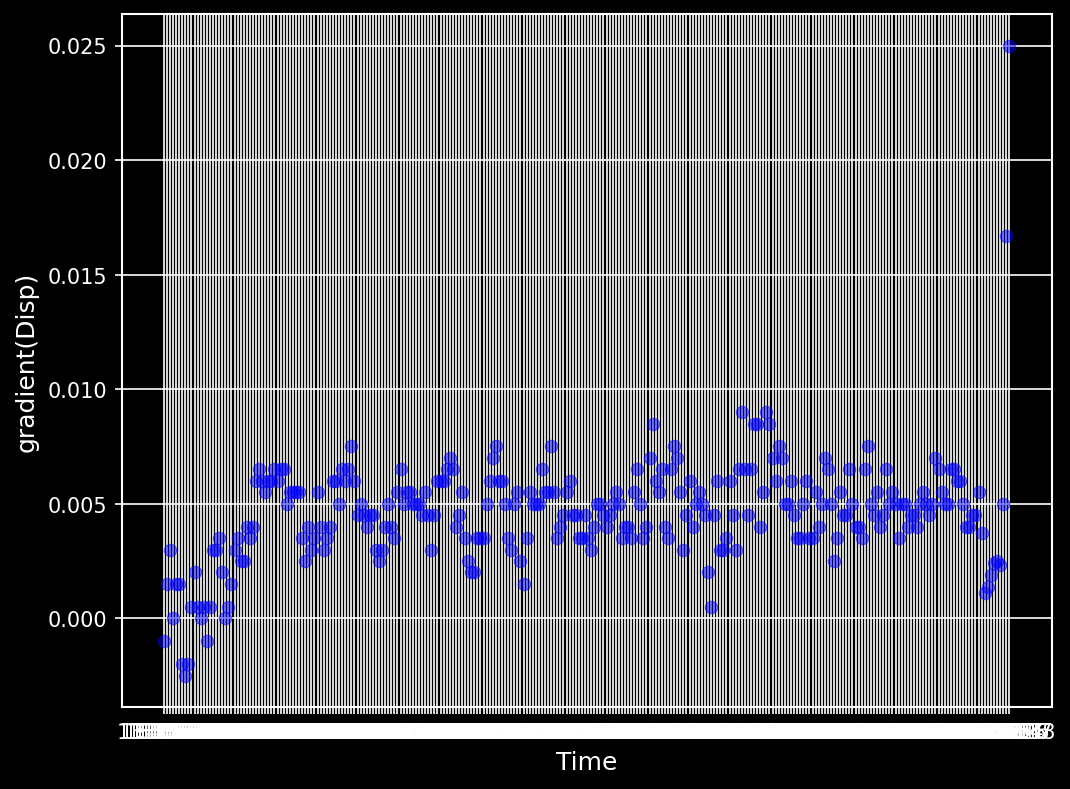

In [25]:
plt.scatter(data['Time'], np.gradient(data['Disp_avg10_mm']), label='Data AVG10', color='blue', alpha=0.5)
# plt.plot(background_X, background_fit, label='Fitted Polynomial', color='red')
plt.xlabel('Time')
plt.ylabel('gradient(Disp)')
# plt.title('Polynomial Fit')
# plt.legend()
plt.show()

The graph is difficult to interpret. We can use another method to find the start of the test..

### Fit two straight lines to the displacement reading before and after the start of the test to find their crossing

In [65]:
# Fit a polynomial of degree X
degree = 1

t_0_ind = 20
around = 10

x0 = range(0, data['Disp_avg10_mm'].size, 1)
x1 = range(0, t_0_ind-5, 1)
coefficients1 = np.polyfit(x1, data['Disp_avg10_mm'][:t_0_ind-5], degree)

# Create a polynomial function from the coefficients
polynomial1 = np.poly1d(coefficients1)

# Generate y-values from the polynomial
Disp_fit1 = polynomial1(x0)

x2 = range(t_0_ind+around, data['Disp_avg10_mm'].size, 1)
coefficients2 = np.polyfit(x2, data['Disp_avg10_mm'][t_0_ind+around:], degree)

# Create a polynomial function from the coefficients
polynomial2 = np.poly1d(coefficients2)

# Generate y-values from the polynomial
Disp_fit2 = polynomial2(x)

In [91]:
print(Disp_fit2[22:26])
print(data['Time'][22:26])
t_0_ind = 23
around_minus = 3
t_0 = data['Time'][t_0_ind]
print('t_0: ', t_0)
F_t_0 = np.mean(data['F_N'][0:t_0_ind-around_minus])
Disp_t_0 = np.mean(data['Disp_mm'][0:t_0_ind-around_minus])
Disp_t_0 = np.mean(Disp_fit1[0:t_0_ind-around_minus])

print('F_t_0: ', F_t_0)
print('Disp_t_0: ', Disp_t_0)

[-0.00507286 -0.00012824  0.00481639  0.00976102]
22    13:54:04
23    13:54:05
24    13:54:06
25    13:54:07
Name: Time, dtype: object
t_0:  13:54:05
F_t_0:  -2.515
Disp_t_0:  -0.004665476190476189


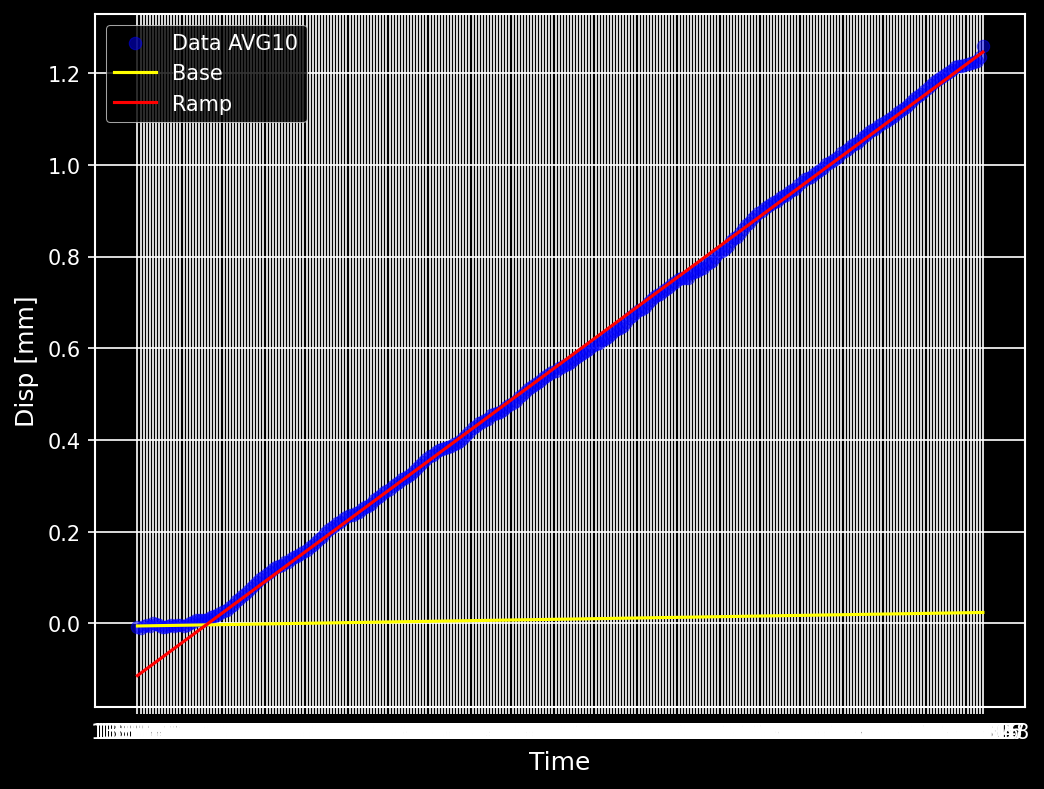

In [66]:
plt.scatter(data['Time'], data['Disp_avg10_mm'], label='Data AVG10', color='blue', alpha=0.5)
plt.plot(data['Time'], Disp_fit1, label='Base', color='yellow')
plt.plot(data['Time'], Disp_fit2, label='Ramp', color='red')
plt.xlabel('Time')
plt.ylabel('Disp [mm]')
# plt.title('Polynomial Fit')
plt.legend()
plt.show()

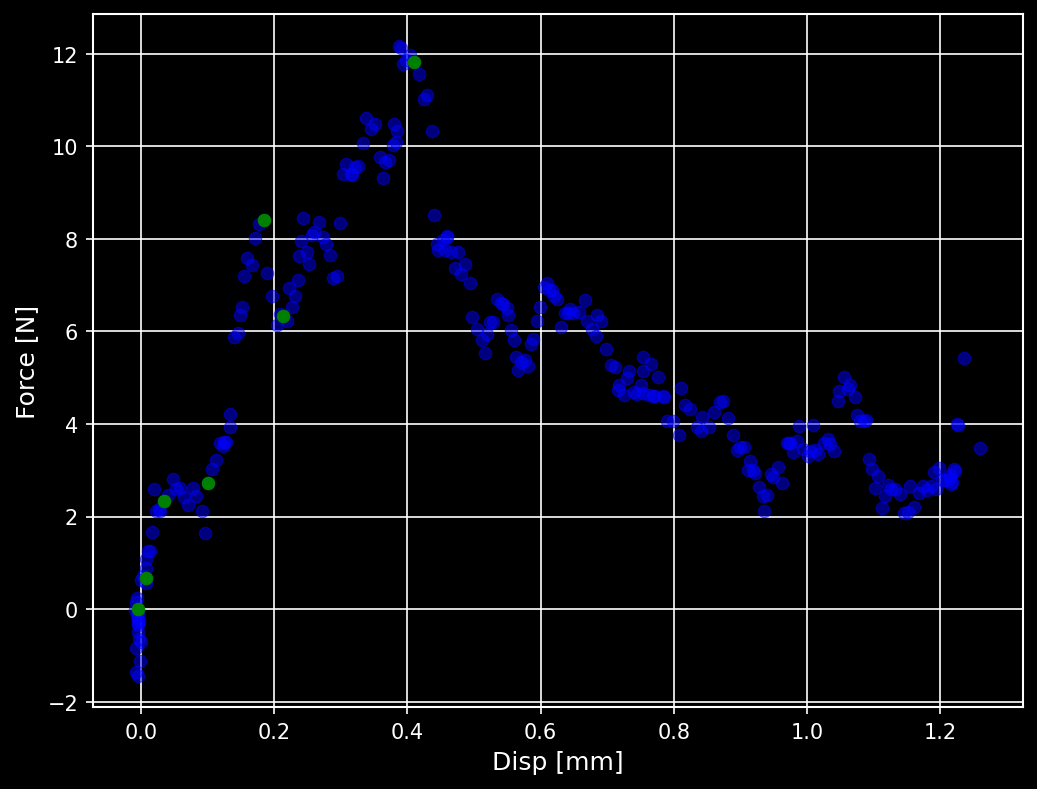

In [159]:
t_step_ind = [t_0_ind-around_minus, 30, 41, 59, 64, 107]

# Plot the original data and the fitted polynomial
plt.scatter(data['Disp_avg10_mm'], data['F_avg10_N']+F_t_0, label='Data AVG10', color='blue', alpha=0.5)
plt.scatter(Disp_t_0, 0, label='Start', color='green', alpha=1)
plt.scatter(data['Disp_avg10_mm'][t_step_ind], data['F_avg10_N'][t_step_ind]+F_t_0, label='Start', color='green', alpha=1)

plt.xlabel('Disp [mm]')
plt.ylabel('Force [N]')
# plt.title('Polynomial Fit')
# plt.legend()
plt.show()

## Fit ramps of F-u curve

In [261]:
frame_rate = 84.1 # [1/s]
frame_0 = 3700

In [233]:
tmp = np.array(2)
tmp = [np.datetime64(pd.Timestamp(data['Time'][30])), np.datetime64(pd.Timestamp(data['Time'][30]))]
print(tmp)


[numpy.datetime64('2024-10-18T13:54:12.000000'), numpy.datetime64('2024-10-18T13:54:12.000000')]


In [255]:
# step_time = pd.to_datetime(data['Time'][t_step_ind])

Step:  0
Coefficients:  [75.16611296  2.84134219]
Time START:  13:54:02
Time END:  13:54:12
F START (fit):  0.8525049833887044  [N]
F END (fit):  2.5061594684385384  [N]
Step:  1
Coefficients:  [84.55639533 -3.93520278]
Time START:  13:54:23
Time END:  13:54:41
F START (fit):  2.089993153029782  [N]
F END (fit):  8.516279198377788  [N]
Step:  2
Coefficients:  [25.51969412  3.64317921]
Time START:  13:54:46
Time END:  13:55:29
F START (fit):  6.563874057991708  [N]
F END (fit):  11.43813563557133  [N]


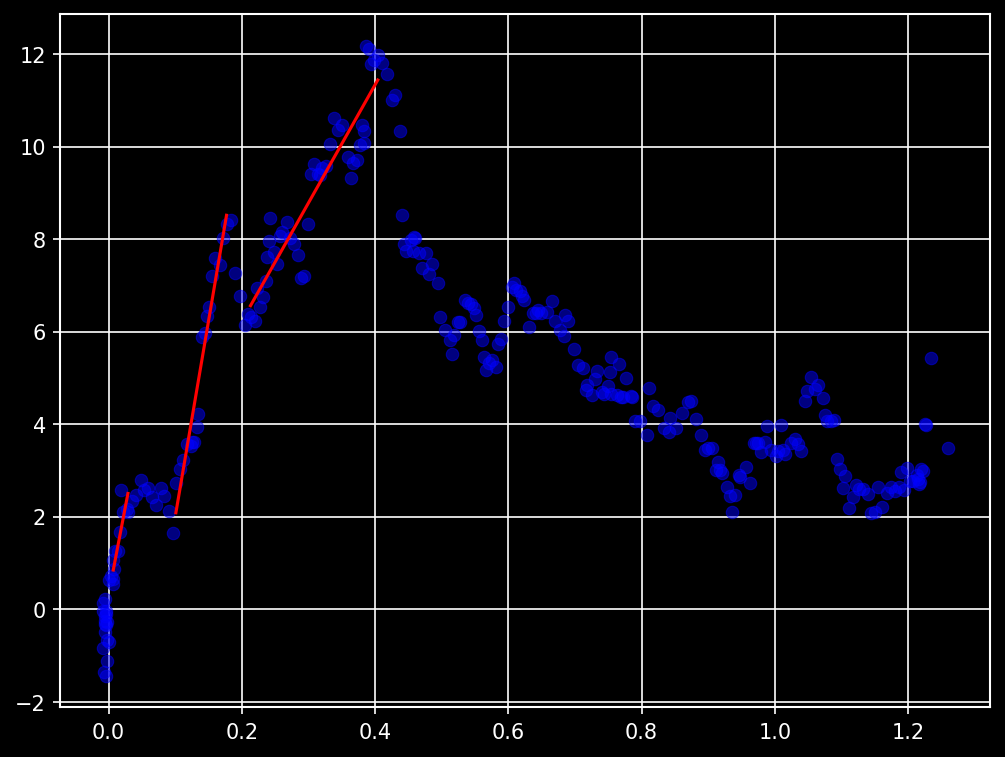

In [271]:
# Fit a polynomial of degree X
degree = 1
# step_time = np.zeros((3,2), dtype=str)
step_seconds = np.zeros(3)
step_time_seconds = np.zeros((3,2))

step_coefficients = np.zeros((3,2))
step_F_fit_N = np.zeros((3,2))

plt.scatter(data['Disp_avg10_mm'], data['F_avg10_N']+F_t_0, label='Data AVG10', color='blue', alpha=0.5)

count = 0
for t_00_ind in t_step_ind[0:5:2]:
    t_01_ind = t_step_ind[2*count+1]

    x = data['Disp_avg10_mm'][t_00_ind:t_01_ind]
    coefficients = np.polyfit(x, data['F_avg10_N'][t_00_ind:t_01_ind], degree)

    # Create a polynomial function from the coefficients
    polynomial = np.poly1d(coefficients)

    # Generate y-values from the polynomial
    F_fit = polynomial(x)

    # plot fit
    plt.plot(x, F_fit+F_t_0, label='Fit ramp', color='red')

    print('Step: ', count)
    print('Coefficients: ', coefficients)
    print('Time START: ', data['Time'][t_00_ind])
    print('Time END: ', data['Time'][t_01_ind])
    print('F START (fit): ', F_fit[0]+F_t_0, ' [N]')
    print('F END (fit): ', F_fit[-1]+F_t_0, ' [N]')

    # step_time[count,:] = [np.datetime64(pd.Timestamp(data['Time'][t_00_ind])), np.datetime64(pd.Timestamp(data['Time'][t_01_ind]))]
    # step_time[count,:] = [data['Time'][t_00_ind], data['Time'][t_01_ind]]
    # , pd.Timestamp(data['Time'][t_00_ind]).to_datetime64()]

    step_seconds[count] = (pd.to_datetime(data['Time'][t_01_ind]) - pd.to_datetime(data['Time'][t_00_ind])).seconds
    step_time_seconds[count,:] = [(pd.to_datetime(data['Time'][t_00_ind]) - pd.to_datetime(data['Time'][t_0_ind-around_minus])).seconds,
                                  (pd.to_datetime(data['Time'][t_01_ind]) - pd.to_datetime(data['Time'][t_0_ind-around_minus])).seconds]    

    step_F_fit_N[count,:] = [F_fit[0]+F_t_0, F_fit[-1]+F_t_0]
    step_coefficients[count,:] = coefficients

    count += 1


plt.show()
    


In [279]:
print(step_time_seconds)

step_frame = frame_0 + (frame_rate * step_time_seconds).astype('int')

print('Step frames: ')
print(step_frame)

[[ 0. 10.]
 [21. 39.]
 [44. 87.]]
Step frames: 
[[ 3700  4541]
 [ 5466  6979]
 [ 7400 11016]]
